In [1]:
import pandas as pd
from constants import *
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# to limit how much data is read in, I use chunksize to load the CSV in smaller chunks, one at a time
# then filter for post 2021 dates only

data_chunks = []
chunksize = 10000

for chunk in pd.read_csv('311_Data.csv', chunksize=chunksize, 
                         parse_dates=['create_date_et'],
                         usecols=lambda column: column not in columns_to_exclude):
   
    filtered_chunk = chunk[chunk['create_date_et'] >= '2021-01-01']
    data_chunks.append(filtered_chunk)

filtered_data = pd.concat(data_chunks, ignore_index=True)

In [3]:
len(filtered_data)

371801

In [4]:
filtered_data.isna().sum()

_id                       0
group_id                  0
num_requests              0
parent_closed             0
status_name               0
status_code               0
dept                   2561
request_type_name         0
request_type_id           0
create_date_et            0
last_action_et            0
closed_date_et        53511
origin                    0
street               166371
street_id            163823
cross_street_id      163823
city                      0
neighborhood          20388
census_tract         142369
council_district      19514
ward                  20350
police_zone           20375
latitude              18257
longitude             18257
geo_accuracy              0
dtype: int64

### Data Cleaning

**The 'request_type_name' column has values such as "Thank you", "Thank You - 311",	"Thank You - Police", "Thank You - EMS". One potential alternative is to combine all this into the "Thank you Umbrella". The drawback is that they have different codes for the department receiving the codes, and this information can be useful for highlighting the kinds of services that a ward or neighborhood receives**

In [5]:
# filtered_data['request_type_name'] = filtered_data['request_type_name'].str.replace(r'(?i)^Thank\s+You\s.*$', 'Thank You', regex=True)

## What is the Distribution of Requests? Does it differ by Year?

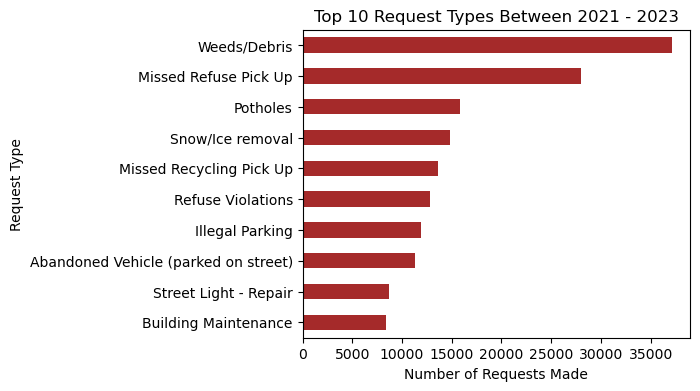

In [8]:
n = 10  # You can change this to the desired number of top values

# Ensure the 'create_date_et' column is in datetime format
filtered_data['create_date_et'] = pd.to_datetime(filtered_data['create_date_et'], errors='coerce')

# Extract the year from 'create_date_et'
filtered_data['year'] = filtered_data['create_date_et'].dt.year
request_type_counts = filtered_data['request_type_name'].value_counts()
top_request_types = request_type_counts.head(n).sort_values(ascending=True)
plt.figure(figsize=(5, 4))
top_request_types.plot(kind='barh', color='brown')

plt.xlabel('Number of Requests Made')
plt.ylabel('Request Type')
plt.title(f'Top {n} Request Types Between 2021 - 2023')
plt.show()

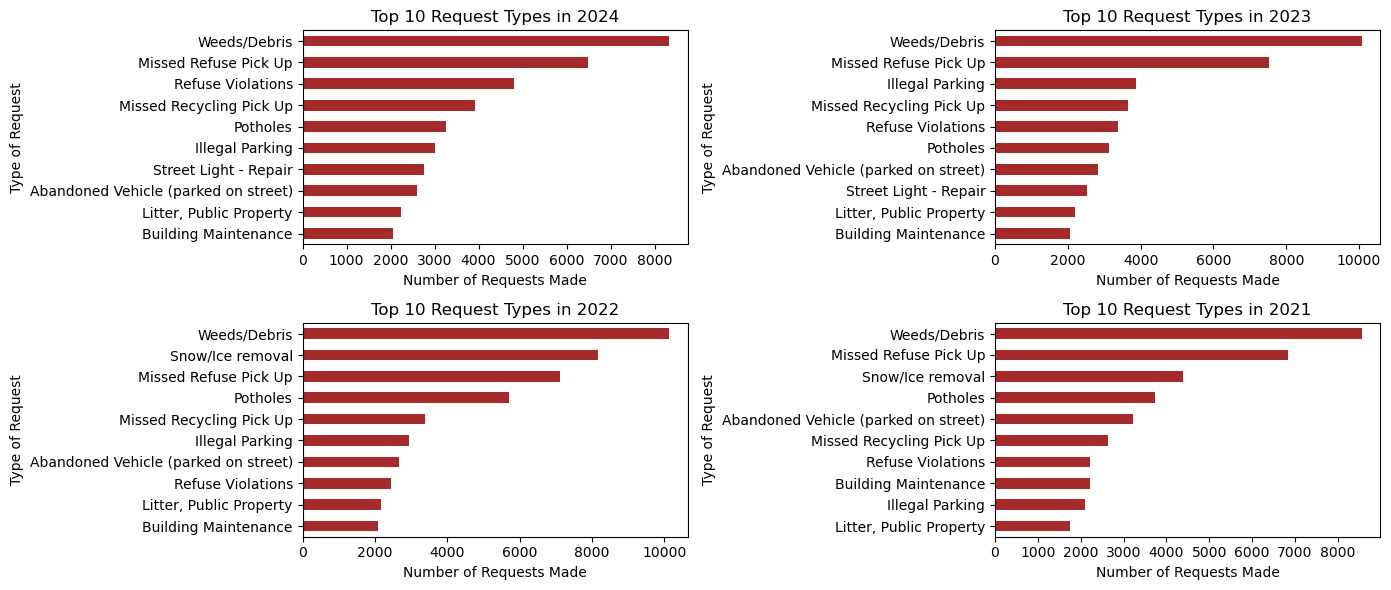

In [9]:

# Create a 2x2 grid of subplots (2 rows, 2 columns), and flatten the axes for easy iteration
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
axes = axes.flatten()

for i, year in enumerate(filtered_data['year'].unique()):
    yearly_requests = filtered_data[filtered_data['year'] == year]
    request_type_counts = yearly_requests['request_type_name'].value_counts()
    top_request_types = request_type_counts.head(n).sort_values(ascending=True)

    # Plotting on the respective subplot (axes[i])
    top_request_types.plot(kind='barh', color='brown', ax=axes[i])

    axes[i].set_xlabel('Number of Requests Made')
    axes[i].set_ylabel('Type of Request')
    axes[i].set_title(f'Top {n} Request Types in {year}')

plt.tight_layout()
plt.show()


## What is the Geospatial Distribution of the 311 Calls and Reports?

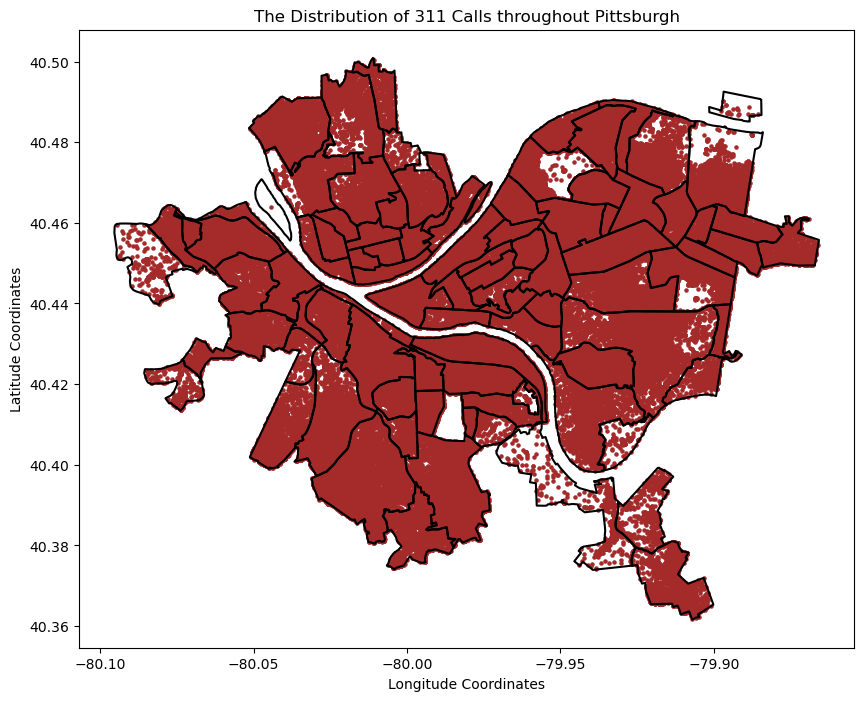

In [10]:
pittsburgh = gpd.read_file('pittsburgh.geojson')
report_locations = gpd.GeoDataFrame(filtered_data, 
                                geometry=gpd.points_from_xy(filtered_data.longitude, filtered_data.latitude),
                                crs=pittsburgh.crs)

report_locations_within_pittsburgh = report_locations[report_locations.geometry.within(pittsburgh.geometry.union_all())]

fig, ax = plt.subplots(1, 1, figsize=(10,10))
pittsburgh.geometry.boundary.plot(ax=ax, color="black")
report_locations_within_pittsburgh.plot(ax=ax, color='brown', marker='o', markersize=5)
plt.title('The Distribution of 311 Calls throughout Pittsburgh')
plt.xlabel('Longitude Coordinates')
plt.ylabel('Latitude Coordinates')
plt.show()

In [14]:
filtered_data.request_type_name.unique()

array(['Park Shelter', 'Illegal Parking', 'City Facility',
       'Thank You - 311', "Mayor's Office", 'Police Department',
       'City Source (CDBG)', 'Missed Refuse Pick Up',
       'Pruning (city tree)', 'Americans with Disabilities',
       'Bike Lane Bollard', 'Thank you - Finance', 'Vacant Lot',
       'Misconduct/City Employee', 'Property Purchase', 'Real Estate Tax',
       'Police Cameras', 'Weeds/Debris', 'SPIN (Stand Up) Scooters',
       'Recycling Questions', 'Public Works Department',
       'Tenant/Landlord Problems', 'Park Ranger',
       'Abandoned Vehicle (parked on street)', 'Neighborhood Issues',
       'Playground', 'Thank You', 'City Owned Property Maintenance',
       'Early Set Out', 'PWSA Billing or Shut Off', 'Homeless',
       'Litter, Public Property', 'Bulk Pick Up', 'Blue Bin Containers',
       'Illegal Dumping', 'City Cuts Application Request',
       'Vacant Building', 'City Council', 'Trail Maintenance',
       'Handicap Parking Signs, Removal', 'Than

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Use TF-IDF Vectorizer to convert request names to vectors
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(filtered_data['request_type_name'])

# Apply KMeans clustering to group similar request types
n_clusters = 10  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
filtered_data['request_cluster'] = kmeans.fit_predict(X)

# Optionally, you can map the cluster numbers to more descriptive labels manually
cluster_labels = {
    0: 'Parking Issues',
    1: 'Public Works',
    2: 'Waste Management',
    3: 'Emergency Services',
    4: 'City Services',
    5: 'Public Safety',
    6: 'Miscellaneous',
    7: 'Community Issues',
    8: 'Environmental Issues',
    9: 'Administrative Issues',
}

# Map the cluster numbers to their corresponding category labels
filtered_data['request_category'] = filtered_data['request_cluster'].map(cluster_labels)

# Check the new categories
print(filtered_data[['request_type_name', 'request_category']].head())


  request_type_name      request_category
0      Park Shelter        Parking Issues
1      Park Shelter        Parking Issues
2      Park Shelter        Parking Issues
3   Illegal Parking  Environmental Issues
4     City Facility        Parking Issues


In [16]:
filtered_data[filtered_data['request_category']=='Parking Issues']['request_type_name']

0                          Park Shelter
1                          Park Shelter
2                          Park Shelter
4                         City Facility
5                       Thank You - 311
                      ...              
371794                Parking Authority
371796              Blue Bin Containers
371797    Construction Site Maintenance
371799              Blue Bin Containers
371800              Stump Grind/Removal
Name: request_type_name, Length: 220845, dtype: object